# This ipython notebook generates inputs for the methodology that willbe used more than once

For example, the code here generates the energy structure used and the smoothed open count data.


In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import syndat
import nuctools

Above we import all necessary python packages as well as the syndat package.

Note below that if you are running jupyter notebook not in VSCode, the matplotlib magic should be "%matplotlib notebook".

In [2]:
%matplotlib widget

In [3]:

sammy_directory =  os.path.realpath('../synthetic_data/Ta181')
opendata = os.path.join(sammy_directory,'rpi-open-ta181.csv')
sammy_xs = os.path.join(sammy_directory,'SAMMY.LST')



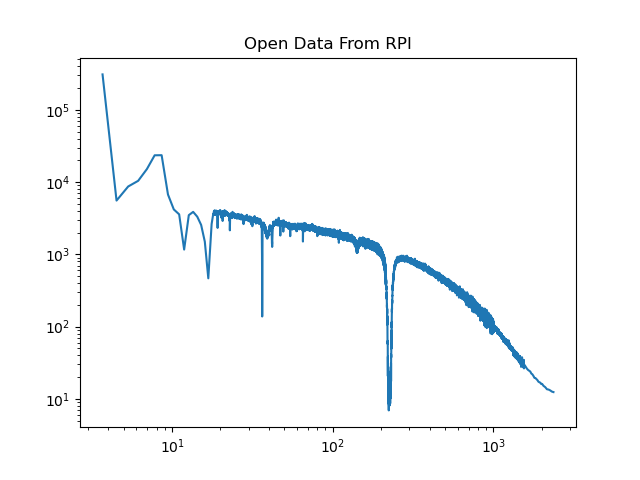

In [4]:
gen = syndat.generation(True, True, True, opendata, sammy_xs)
figure()
title('Open Data From RPI')
plot(gen.odat.tof, gen.odat.cps)
xscale('log'); yscale('log')


The energy structure will be pulled from the open data.

In [13]:

E = syndat.exp_effects.t_to_e((gen.odat.tof+gen.redpar.val.t0)*1e-6, gen.redpar.val.tof_dist, True)
tof = syndat.exp_effects.e_to_t(E,gen.redpar.val.tof_dist, True)*1e6-gen.redpar.val.t0

In [14]:
gen.odat.E
syndat.sammy_interface.write_estruct_file(gen.odat.E, '../synthetic_data/Ta181/estruct')

See 'sammy_interface.write_estruct_file'


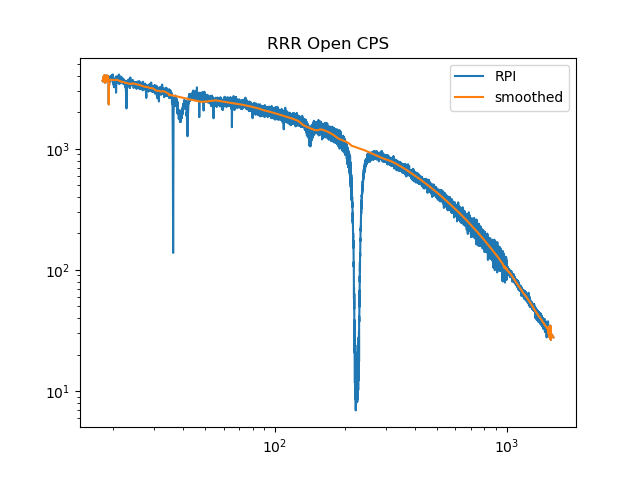

In [15]:
# y,dy = nuctools.tof_tools.sgfilter(gen.odat.c, gen.odat.dc, 1001, 2, deriv=0)

# ycps, dycps = syndat.cts_to_ctr(y,dy, gen.odat.bw, gen.redpar.val.trig)

# isolate the RRR
RRR_odat = gen.odat.loc[(gen.odat['tof']>18) & (gen.odat['tof']<1600)]

# y,dy = nuctools.tof_tools.sgfilter(RRR_odat.cps, RRR_odat.dcps, 10001, 4, deriv=0)
exp_func = 3700*np.exp(-4500*(1e-6*RRR_odat.tof))-300

notch_corrected_cps = np.where((RRR_odat.tof<250)&(RRR_odat.tof>200), exp_func, RRR_odat.cps)
middle_smooth, dy = nuctools.tof_tools.sgfilter(notch_corrected_cps, notch_corrected_cps, 1001, 1, deriv=0)
middle_smoothed_cps = np.where((RRR_odat.tof<975)&(RRR_odat.tof>35), middle_smooth, notch_corrected_cps)
outer_smooth, dy = nuctools.tof_tools.sgfilter(notch_corrected_cps, notch_corrected_cps, 101, 1, deriv=0)

smoothed_cps = np.where((RRR_odat.tof>975)|(RRR_odat.tof<35), outer_smooth, middle_smoothed_cps)

figure()
title('RRR Open CPS')
plot(RRR_odat.tof, RRR_odat.cps, label='RPI')
# plot(RRR_odat.tof, y)
# plot(RRR_odat.tof, notch_corrected_cps)
plot(RRR_odat.tof, smoothed_cps, label='smoothed')
xscale('log');yscale('log')
legend()

In [16]:
smoothed_odat = RRR_odat.loc[:,('tof','bin_width', 'E','bw')]
smoothed_odat['cps'] = smoothed_cps
smoothed_odat['c'] = smoothed_cps*smoothed_odat.bw*gen.redpar.val.trig

smoothed_odat

,tof,bin_width,E,bw,cps,c
18,18.0384,0.0256,14177.483896,2.560000e-08,3657.306997,913.87219
19,18.0640,0.0256,14143.567618,2.560000e-08,3640.892757,909.77067
20,18.0896,0.0256,14109.772901,2.560000e-08,3589.706070,896.98036
21,18.1152,0.0256,14076.099164,2.560000e-08,3604.853760,900.76540
22,18.1408,0.0256,14042.545831,2.560000e-08,3730.005460,932.03777
...,...,...,...,...,...,...
16018,1548.4704,0.8192,2.687208,8.192000e-07,32.655735,261.11600
16019,1549.2896,0.8192,2.684373,8.192000e-07,26.440740,211.42076
16020,1550.1088,0.8192,2.681543,8.192000e-07,27.279082,218.12416
16021,1563.6256,26.2144,2.635479,2.621440e-05,29.389765,7520.03933


In [18]:
# write estruct file for smooth open data
syndat.sammy_interface.write_estruct_file(smoothed_odat.E, '../synthetic_data/Ta181/estruct_smoothopen')

See 'sammy_interface.write_estruct_file'


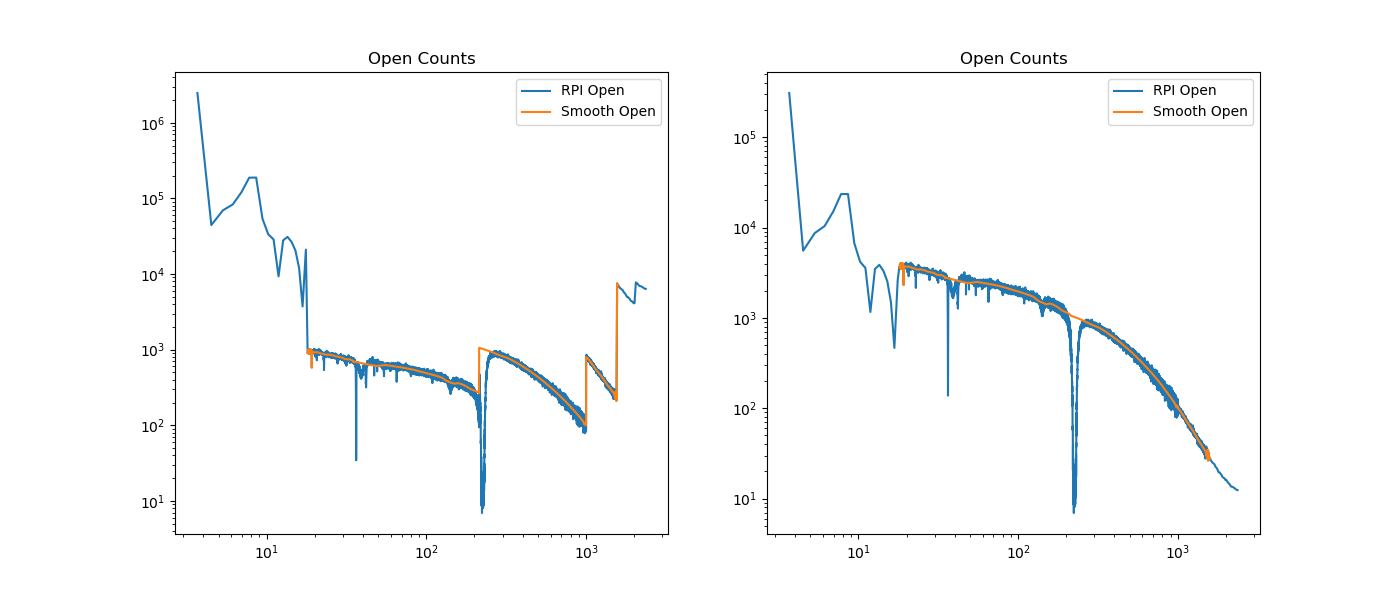

In [184]:
fig,ax = subplots(1,2, figsize=(14,6))

ax[0].set_title('Open Counts')
ax[0].plot(gen.odat.tof, gen.odat.c, label='RPI Open')
ax[0].plot(smoothed_odat.tof, smoothed_odat.c, label='Smooth Open')
ax[0].legend()
ax[0].set_xscale('log'); ax[0].set_yscale('log')

ax[1].set_title('Open Count Rate')
ax[1].plot(gen.odat.tof, gen.odat.cps, label='RPI Open')
ax[1].plot(smoothed_odat.tof, smoothed_odat.cps, label='Smooth Open')
ax[1].legend()
ax[1].set_xscale('log'); ax[1].set_yscale('log')

In [192]:

write_odat = smoothed_odat.loc[:,('tof','bin_width','c')]
write_odat['dcounts'] = np.sqrt(write_odat.c)
write_odat.rename(columns={'c':'counts'}, inplace=True)
write_odat.to_csv('../synthetic_data/Ta181/smooth-open-Ta181.csv', index=False)
# write_odat